In [12]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine

2015년부터 5년간 비트코인의 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [13]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
time,,,,,,,,,
2015-01-14,178.102997,0.305428,14.623696,-13.092559,-22.733852,256.836048,97638704,4.427062,5.319966
2015-01-15,209.843994,0.294917,29.526698,-15.493588,-25.097704,249.223158,81773504,22.827701,11.164776
2015-01-16,208.097000,0.109225,29.224329,-17.755485,-26.803072,246.667251,38421000,5.796438,9.373512
2015-01-17,199.259995,0.086496,27.680181,-19.912125,-28.538685,244.963144,23469700,3.446131,7.396380
2015-01-18,210.339005,0.124361,32.495837,-21.667595,-28.689473,243.234251,30085100,12.443029,9.079356
...,...,...,...,...,...,...,...,...,...
2022-04-03,46453.566406,0.036801,62.303913,1435.035525,1601.875496,27629.222968,25414397610,11.045745,9.406373
2022-04-04,46622.675781,0.034381,62.867034,1464.319866,1581.457230,27643.926784,32499785455,19.427733,12.746826
2022-04-05,45555.992188,0.034281,57.075330,1463.925120,1462.346140,27657.210382,29640604055,0.180110,8.557921


In [14]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
count,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2.641000e+03,2641.000000,2641.000000
mean,12361.548125,0.048820,54.225067,111.869667,113.876757,7944.732306,1.559105e+10,12.435557,12.435357
std,16640.191315,0.044747,14.107305,917.861620,966.552219,7833.180438,2.011957e+10,10.904669,5.207633
min,178.102997,0.002611,9.920239,-4438.999056,-5053.274080,239.814687,1.060090e+07,0.000000,2.191343
25%,711.619019,0.020125,44.048473,-55.399081,-51.943367,473.107653,1.111580e+08,4.708172,8.665773
50%,6614.180176,0.037020,53.428162,6.855664,7.098488,8344.510794,6.043130e+09,9.438841,11.698033
75%,11182.806641,0.060581,63.583104,221.457013,219.499436,9768.968292,2.609829e+10,16.887146,15.388708
max,67566.828125,0.631387,94.302215,4517.102703,5273.808690,27682.051317,3.509679e+11,94.870806,38.351701


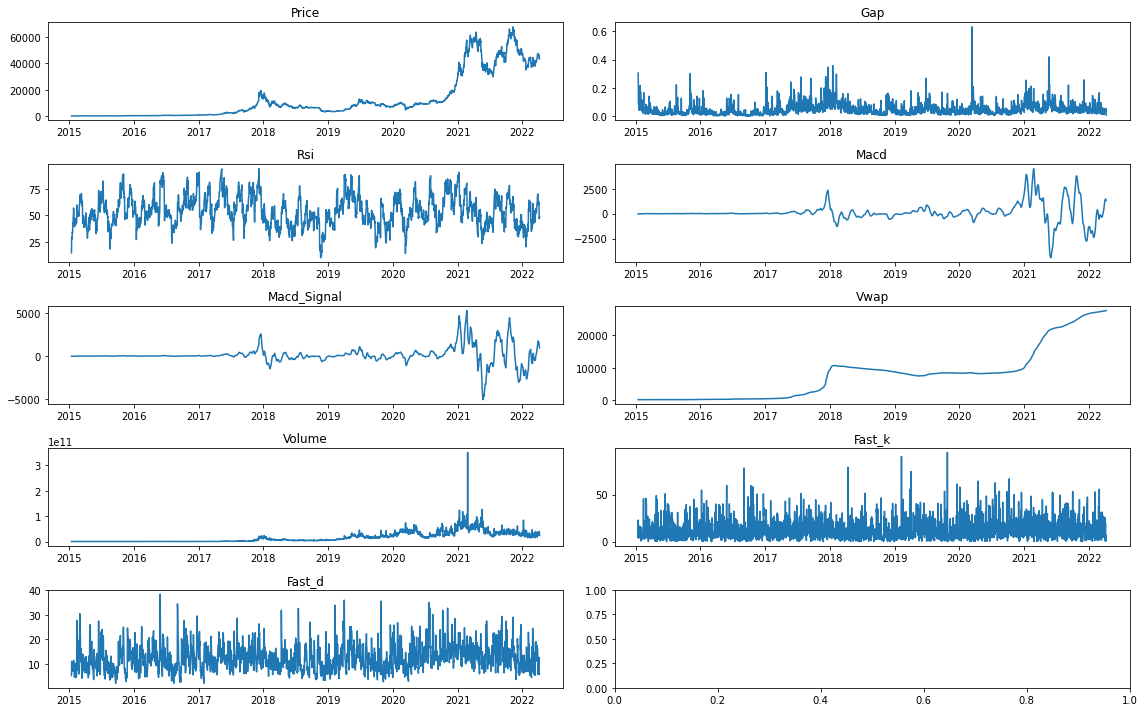

In [15]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

volume은 시간이 지남에 따라 상승하는 경향이 보이므로 이동평균을 통해 나눠준 값을 사용한다.</br>
거래량 = (거래량 / 지난 7일간의 이동 평균 거래량) 평균적인 거래량에 비해 얼마나 더 많이 거래가 발생했는지 확인 가능하다.</br>
가격 역시 시간이 지남에 따라 자연히 증가하므로 전일 대비 증감률을 사용한다.

이렇게 데이터를 변형해 줌으로써 모델은 가격이 시간이 지남에 따라 자연히 증가하는 것이 아니라 학습 할 수 있다. </br>

In [16]:
volume_mva = df['Volume'].rolling(window = 7).mean()
df['Volume'] = df['Volume'] / volume_mva
df['Pct'] = df['Price'].pct_change() * 100
df = df.apply(lambda x: x.round(3)) #적당히 값을 묶어주기 위해 소수점 3자리를 기점으로 반올림을 진행한다.
df = df.dropna() #결측치를 제거해준다.
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Pct
time,,,,,,,,,,
2015-01-20,211.315,0.049,33.608,-23.894,-27.636,241.273,0.536,4.843,6.966,-1.650
2015-01-21,226.897,0.078,40.240,-24.255,-25.699,240.469,0.850,12.791,8.908,7.374
2015-01-22,233.406,0.047,42.810,-24.078,-23.369,240.104,1.185,5.829,7.882,2.869
2015-01-23,232.879,0.043,42.650,-23.526,-21.320,239.815,0.935,6.588,7.451,-0.226
2015-01-24,247.847,0.079,48.531,-22.476,-18.277,239.883,0.934,16.485,10.462,6.427
...,...,...,...,...,...,...,...,...,...,...
2022-04-03,46453.566,0.037,62.304,1435.036,1601.875,27629.223,0.797,11.046,9.406,1.275
2022-04-04,46622.676,0.034,62.867,1464.320,1581.457,27643.927,1.037,19.428,12.747,0.364
2022-04-05,45555.992,0.034,57.075,1463.925,1462.346,27657.210,0.953,0.180,8.558,-2.288


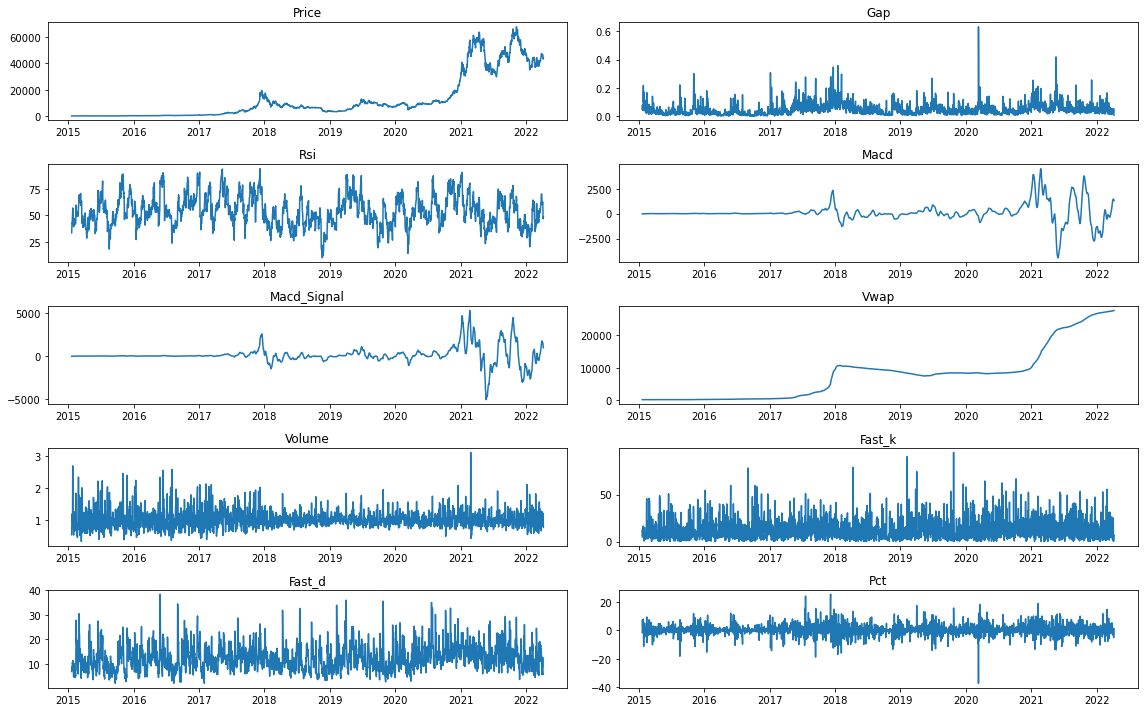

In [17]:
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns,start=1):
        plt.subplot(rows, 2, i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

Volume과 Pct를 보면 동일하게 거래량과 가격에 관한 지표를 나타내지만, 선형성이 사라진 것을 확인 할 수 있다. </br>
이제 모델은 무작정 시간이 지남에 따라 값이 증가한다고 예측하지 못한다.

<AxesSubplot:>

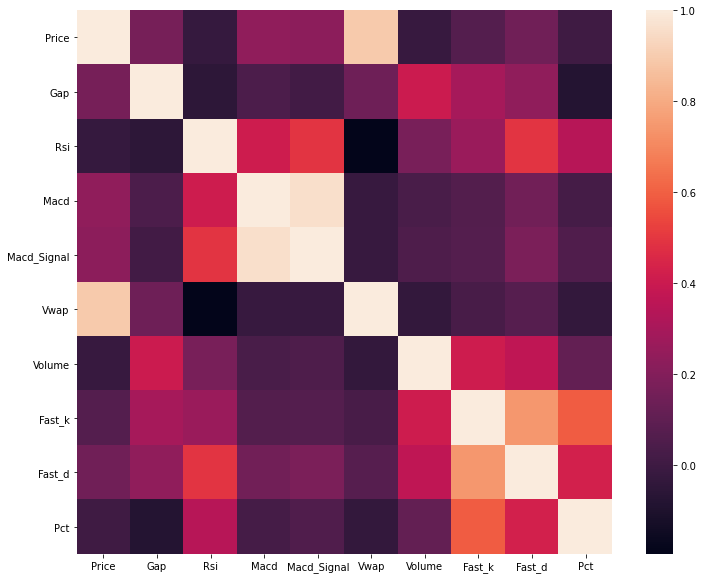

In [18]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [19]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Pct
Price,1.0000,NaN,NaN,NaN,NaN,0.8932,NaN,NaN,NaN,NaN
Gap,NaN,1.000000,NaN,NaN,NaN,NaN,0.402967,NaN,NaN,NaN
Rsi,NaN,NaN,1.000000,0.409827,0.490921,NaN,NaN,NaN,0.495074,0.346057
Macd,NaN,NaN,0.409827,1.000000,0.960943,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,NaN,0.490921,0.960943,1.000000,NaN,NaN,NaN,NaN,NaN
Vwap,0.8932,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,NaN,NaN
Volume,NaN,0.402967,NaN,NaN,NaN,NaN,1.000000,0.408046,0.366939,NaN
Fast_k,NaN,NaN,NaN,NaN,NaN,NaN,0.408046,1.000000,0.747045,0.592671
Fast_d,NaN,NaN,0.495074,NaN,NaN,NaN,0.366939,0.747045,1.000000,0.427525
Pct,NaN,NaN,0.346057,NaN,NaN,NaN,NaN,0.592671,0.427525,1.000000


pct는 Rsi, Fask_k와 깊은 상관성을 보인다.</br>
price는 vwap와 관련이 깊어 보인다. 

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [9]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'Price_change'):
    plt.figure(figsize=(10,10))
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

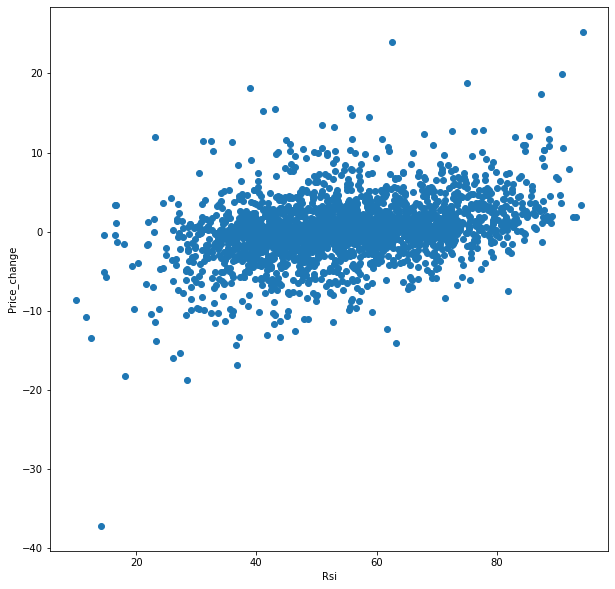

In [10]:
plot_corr(x=df['Rsi'], y=df['Pct'], x_name="Rsi")

VWAP와 가격의 상관 관계
* 강한 양의 상관 관계를 띄지만 파악이 불가한 부분이 존재한다.

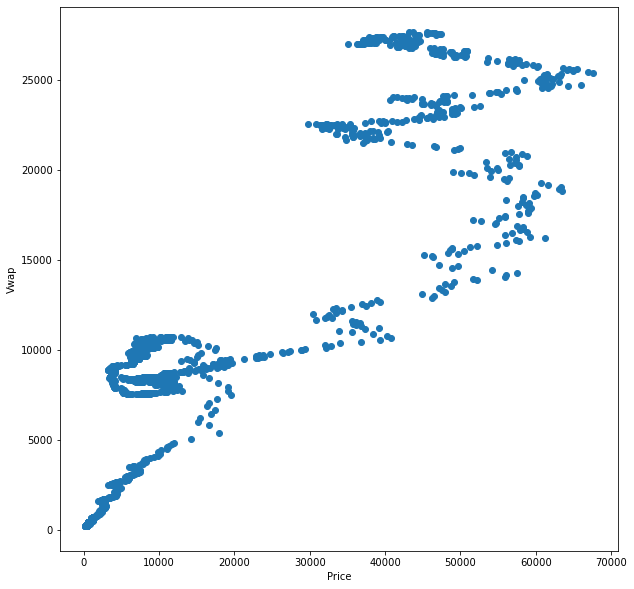

In [20]:
plot_corr(x=df['Price'], y=df['Vwap'], x_name="Price", y_name="Vwap")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [21]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                sell_sign.append(gap.index[i]) 
            else:
                buy_sign.append(gap.index[i])
    return buy_sign, sell_sign

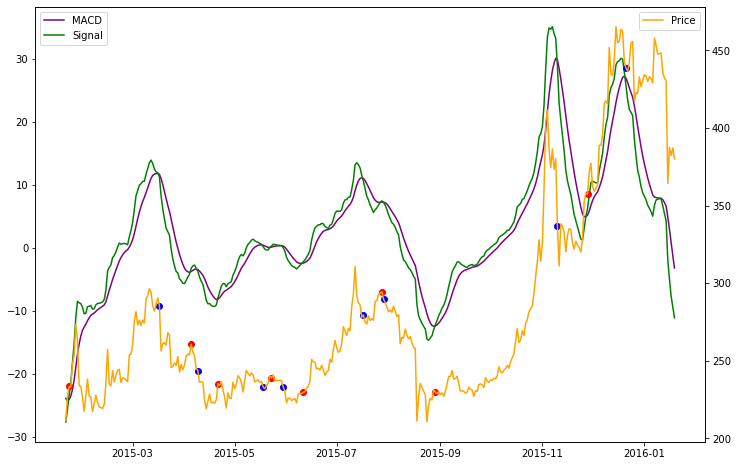

In [22]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:365],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

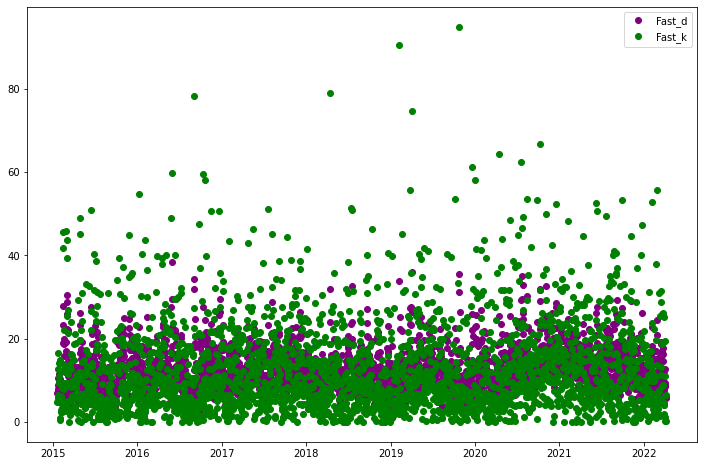

In [23]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

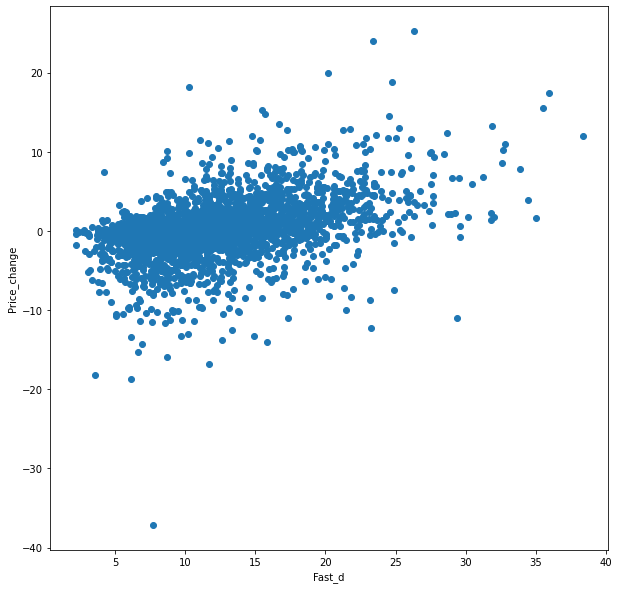

In [24]:
plot_corr(x=df['Fast_d'], y=df['Pct'],x_name="Fast_d")

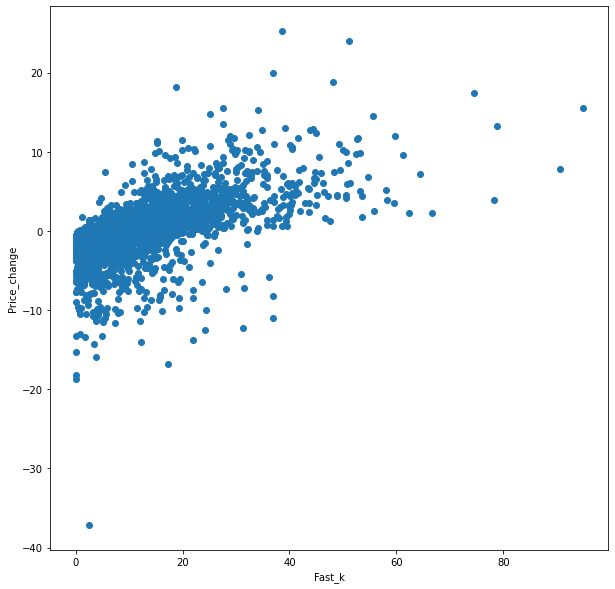

In [25]:
plot_corr(x=df['Fast_k'],y=df['Pct'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Gap: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [26]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df.drop(["Macd","Fast_k","Volume","Gap"], axis=1)
new_df["Macd_Gap"] = macd_gap
new_df

,Price,Rsi,Macd_Signal,Vwap,Fast_d,Pct,Macd_Gap
time,,,,,,,
2015-01-20,211.315,33.608,-27.636,241.273,6.966,-1.650,-3.742
2015-01-21,226.897,40.240,-25.699,240.469,8.908,7.374,-1.444
2015-01-22,233.406,42.810,-23.369,240.104,7.882,2.869,0.709
2015-01-23,232.879,42.650,-21.320,239.815,7.451,-0.226,2.206
2015-01-24,247.847,48.531,-18.277,239.883,10.462,6.427,4.199
...,...,...,...,...,...,...,...
2022-04-03,46453.566,62.304,1601.875,27629.223,9.406,1.275,166.839
2022-04-04,46622.676,62.867,1581.457,27643.927,12.747,0.364,117.137
2022-04-05,45555.992,57.075,1462.346,27657.210,8.558,-2.288,-1.579


#### 모멘텀 지표
* 추가적으로 특정 주기별 비트코인의 기하 평균 수익률을 기록하는 모멘텀 지표를 추가해준다.
* 모멘텀 지표를 통해 추세를 확인 할 수 있다.

In [27]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed

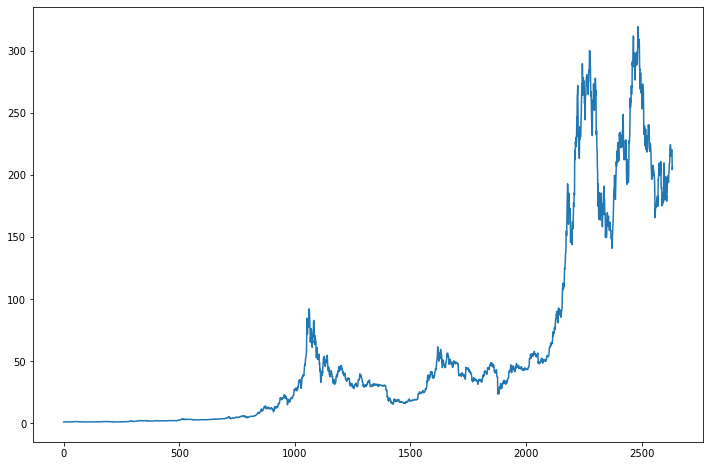

In [33]:
plt.figure(figsize=(12,8))
plt.plot(get_profit(new_df['Pct'] / 100))

In [ ]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'] / 100)) #profit은 실제 내 수익률을 보여준다.
w2 = profit.rolling(14).apply(lambda x: x.prod() ** (1.0 / 14)) #2주 간의 기하 평균 수익률
m1 = profit / profit.rolling(30).apply(lambda x: x.prod() ** (1.0 / 30)) #1달 간의 기하 평균 수익률
m2 = profit / profit.rolling(60).apply(lambda x: x.prod() ** (1.0 / 60)) #2달 간의 기하 평균 수익률
momentum = (w2 * 0.5 + m1 * 0.3 + m2 * 0.2).dropna()

* 모멘텀 지표는 실제 수익률 그래프와 비교했을 때 평균을 활용하기에 훨씬 부드럽고 </br>
전반적인 추세 파악에 유용하다.

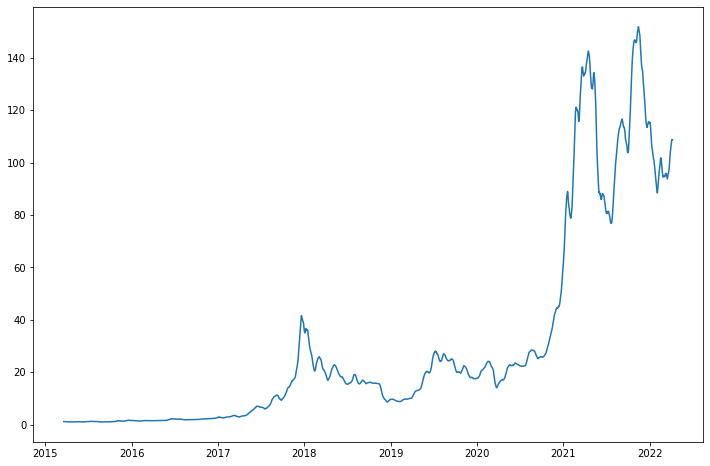

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(momentum)

In [35]:
momentum.index = new_df.index[59:] #모멘텀 지표를 df에 추가해준다.
momentum.name = "Moment"
moment_df = new_df.join(momentum).dropna()
moment_df

,Price,Rsi,Macd_Signal,Vwap,Fast_d,Pct,Macd_Gap,Moment
time,,,,,,,,
2015-03-20,261.749,45.811,4.559,250.978,11.061,0.315,-4.369,1.169868
2015-03-21,260.025,44.925,3.102,251.034,10.211,-0.659,-4.660,1.162174
2015-03-22,267.960,49.742,2.558,251.140,12.235,3.052,-4.164,1.174816
2015-03-23,266.740,49.032,2.006,251.295,11.395,-0.455,-3.772,1.167267
2015-03-24,245.595,38.716,-0.137,251.309,8.498,-7.927,-4.732,1.118174
...,...,...,...,...,...,...,...,...
2022-04-03,46453.566,62.304,1601.875,27629.223,9.406,1.275,166.839,107.226233
2022-04-04,46622.676,62.867,1581.457,27643.927,12.747,0.364,117.137,108.194812
2022-04-05,45555.992,57.075,1462.346,27657.210,8.558,-2.288,-1.579,108.741086


#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


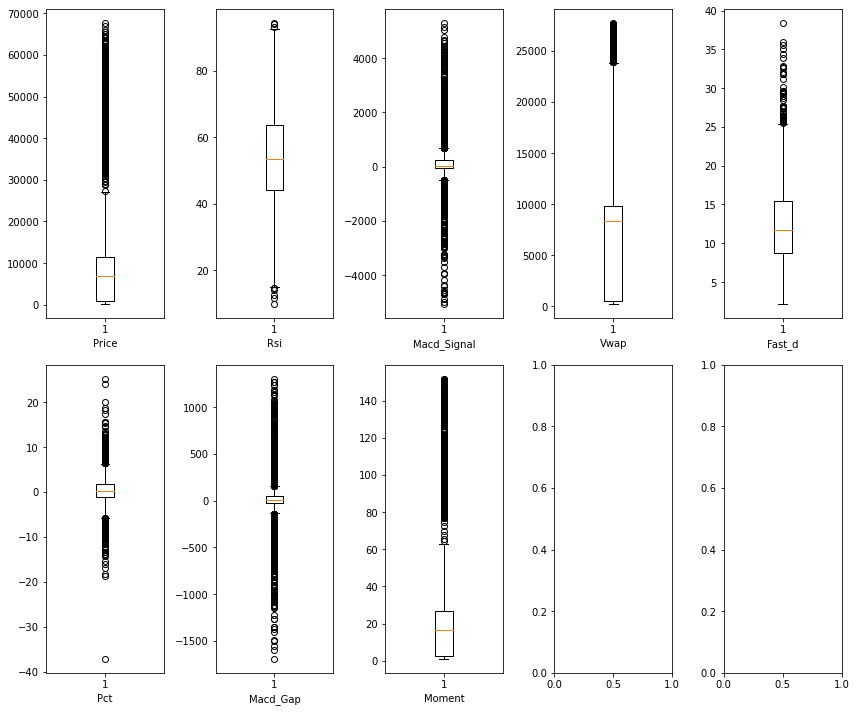

In [36]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(moment_df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(moment_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [37]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


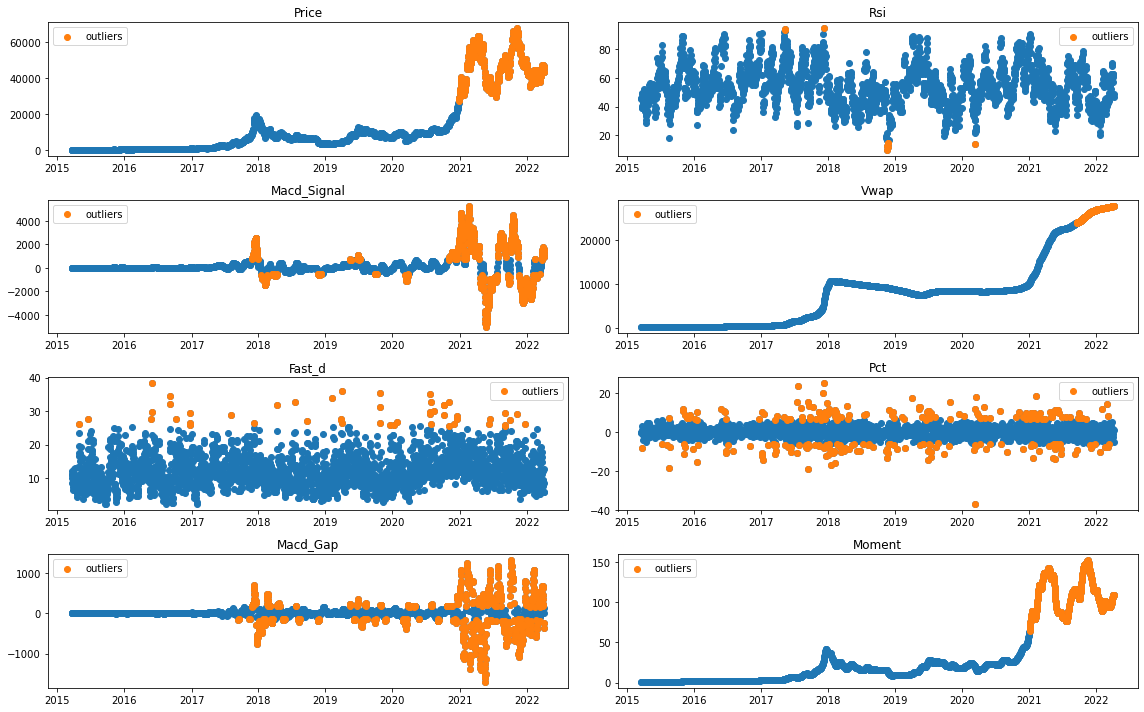

In [38]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index,y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(moment_df)
draw_outlier(outliers_cols, moment_df)

피쳐별로 아웃라이어를 모조리 제거해 주기에는 문제가 있다. </br>
RSI에서 잡힌 아웃라이어 정도만 제거해준다.

In [39]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Pct: 268
Fast_d: 49
Rsi: 9
Macd_Gap: 639
Macd_Signal: 577
Price: 465
Moment: 460
Vwap: 201


<AxesSubplot:>

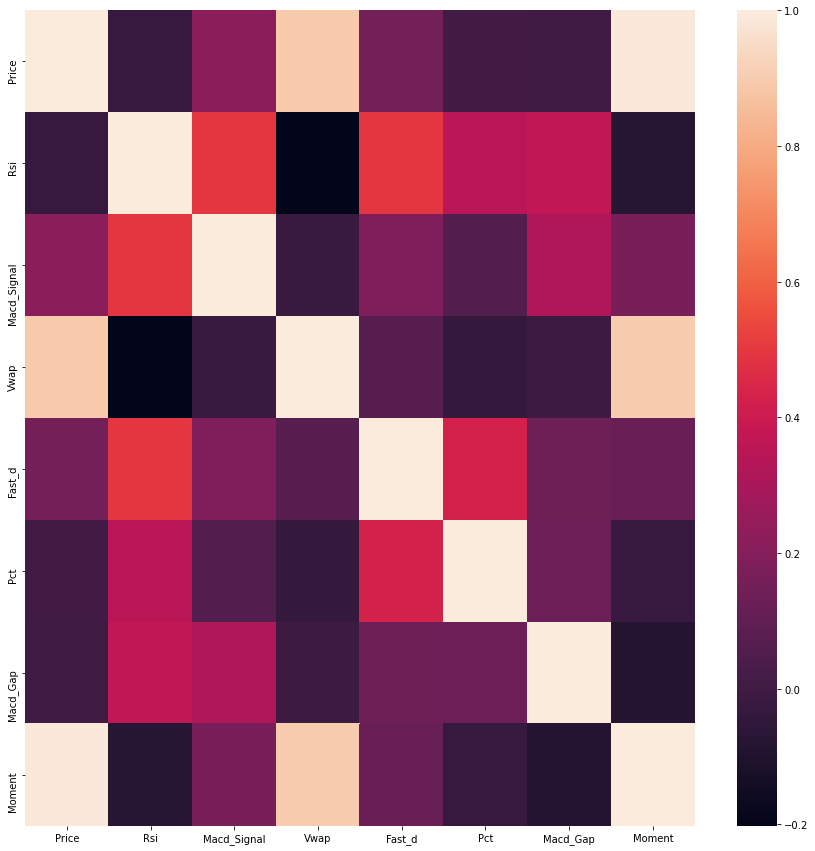

In [40]:
corr = moment_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 큰 연관성은 없어 보이지만, 전반적인 수익률 곡선의 추세를 보여주기에 사용했다.</br>
기존에 존재하는 듀얼 모멘텀 전략 등에서의 아이디어를 활용할 수는 없을까? 라는 가정에서 출발했다.</br>
모멘트 팩터는 실상 조금 완만한 가격 데이터라 해도 과언이 아니다.

모델을 생성하고 비교해보자.

In [41]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [42]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Price'], axis=1).iloc[1:]
    y = df['Price'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [43]:
train_X, test_X, train_y, test_y = create_train_data(moment_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=10, random_state=42))])

In [44]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 185835845.02294323, alpha: 1000
mse: 94461592.62262253, alpha: 300
mse: 34950221.153258294, alpha: 100
mse: 10875249.267795999, alpha: 30
mse: 3714320.9061213452, alpha: 10
mse: 435542.747738535, alpha: 1
mse: 18002622.921376973, alpha: 1000
mse: 3963248.5951402127, alpha: 300
mse: 2360442.1254419927, alpha: 100
mse: 566848.8502842138, alpha: 30
mse: 381109.868723474, alpha: 10
mse: 322425.3654148386, alpha: 1


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [45]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [46]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar()


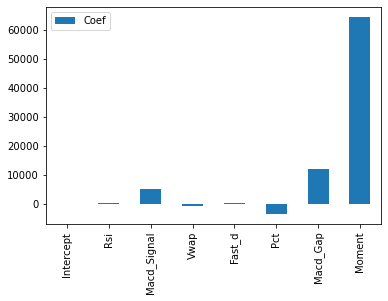

In [47]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns, True)

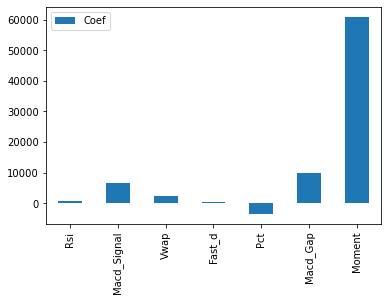

In [48]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

In [49]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

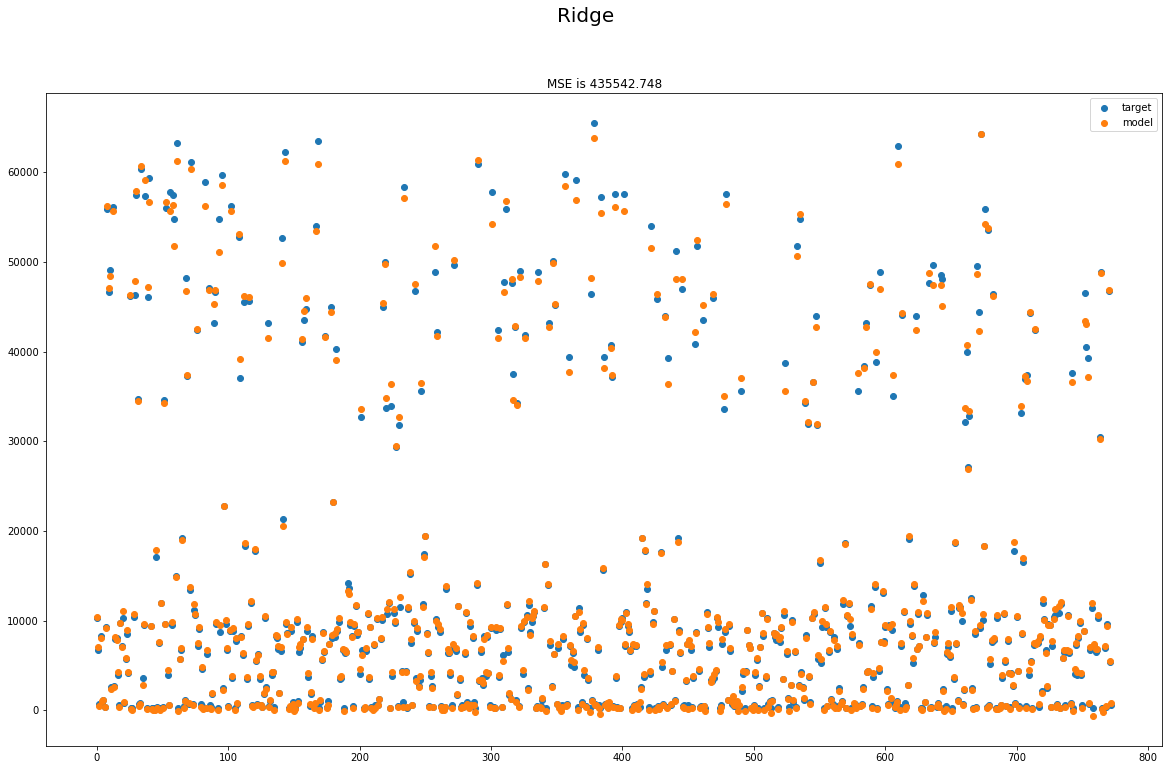

In [50]:
visualize(r_pred, test_y, "Ridge")

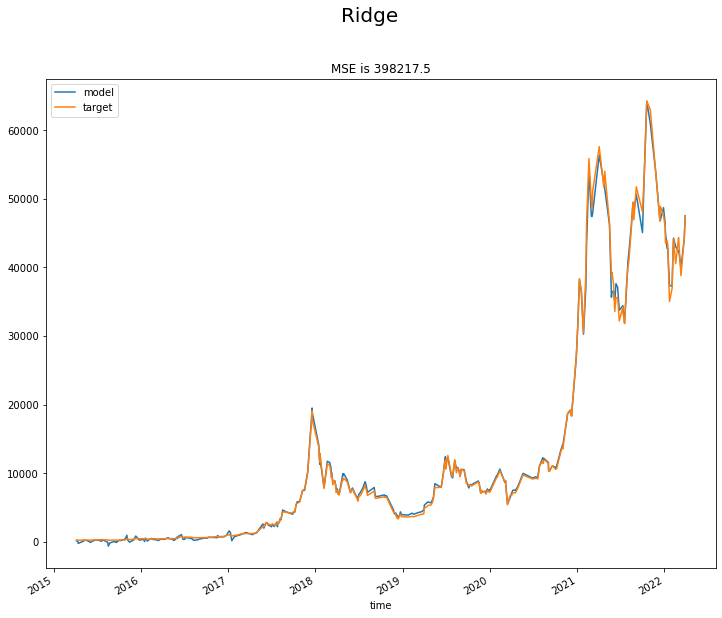

In [54]:
eval_model.visualize_plot(r_pred[-YEAR:], test_y[-YEAR:], "Ridge")


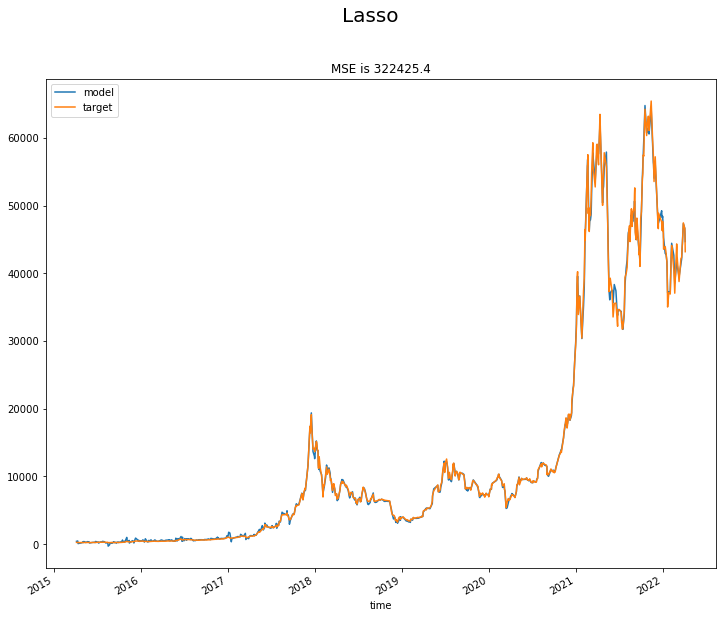

In [52]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")

In [55]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

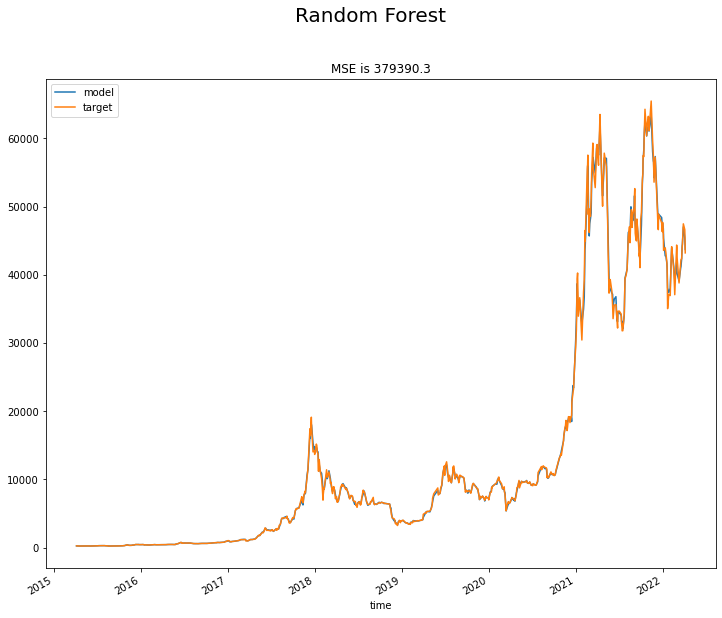

In [56]:
eval_model.visualize_plot(rf_pred, test_y, "Random Forest")

### 모델
* 모델의 성능은 충격적이게도 라쏘가 가장 괜찮은 성능을 보이고 있다. 
* 실상 모맨텀 팩터 하나에만 의지하며 예측을 진행하고 있다.

In [59]:
import joblib
joblib.dump(lasso_model, "Lasso_BTC_only.pkl")
joblib.dump(ridge_model, "Ridge_BTC_only.pkl")

['Ridge_BTC_only.pkl']